# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Data Collection and Organization

### Note: Some price series are not available on non-business days, hence there will be an issue with NaNs. 
### Ideally, we should drop all weekends and holidays 

In [2]:
#Loading the data
VIX_raw = pd.read_csv('data/VIX.csv', header = 2)
DOW_raw = pd.read_csv('data/DOW.csv', header = 2)
GFD_raw = pd.read_csv('data/GFD_TBILL_DAILY.csv', header = 2)
GOLD_raw = pd.read_csv('data/GOLD.csv', header = 2)
SPX_raw = pd.read_csv('data/SPX.csv', header = 2)
# I'm not using US_10YR because it contains duplicate values for many dates
#US_10YR = pd.read_csv('data/US_10yr_yield.csv', header = 2)

In [3]:
# Define a helper function to process the data
def process_data(df, label, feature_engineering = True):
    
    # Convert the Date column from a string to datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Get only the Dates earlier than 2021-10-21 since we aren't predicting into the future
    df = df.loc[(df['Date'] <= '2021-10-21')]
    
    # Carries forward old prices, so we aren't using future information
    df.fillna(method = 'ffill', inplace=True) 
    
    # Drop the 'Ticker' and 'Open' columns
    df = df.drop(columns = ['Ticker', 'Open'], axis=1)
    
    # Take percentage changes
    if feature_engineering == True:
        
        # Grab percentage changes in price
        percentage_changes = df.loc[:, 'Close'].pct_change()
        
        # Daily percentage change feature
        df[label+"_pct_change"] = percentage_changes
        
        # Rolling volatility feature
        long_term_vol = percentage_changes.std()
        rolling_vol_30_day = percentage_changes.rolling(window=30).std() / long_term_vol
        rolling_vol_10_day = percentage_changes.rolling(window=10).std() / long_term_vol
        df[label+"_rolling_vol_30D"] = rolling_vol_30_day
        df[label+"_rolling_vol_10D"] = rolling_vol_10_day
        
    else:
        # Just label the closing price column with passed label
        df[label] = df.loc[:,'Close']
    
    # Reverse the data to go backward in time
    df = df.sort_values(by='Date', ascending=False).reset_index(drop=True)
    
    # Rename the 'Close' column with the passed label
    #df = df.rename(columns={'Close': label})
    df = df.drop(columns = 'Close')
    
    return df

# Process all of the data
VIX = process_data(VIX_raw, 'VIX', feature_engineering = False) # We predict raw VIX levels.
DOW = process_data(DOW_raw, 'DOW')
GFD = process_data(GFD_raw, 'TBILL')
GOLD = process_data(GOLD_raw, 'GOLD')
SPX = process_data(SPX_raw, 'SPX')
#US_10YR = process_data(US_10YR, 'US_10YR')


# Merge all of the data into one large dataframe
from functools import reduce

dfs = [VIX, DOW, GFD, GOLD, SPX]
#dfs = [VIX, DOW, GFD, GOLD, SPX, US_10YR]
data = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), dfs)

# Sort the data by descending date
data = data.sort_values(by='Date', ascending=False).reset_index(drop=True)

# Absent values should have percentage changes of zero. 
# But we want to front-fill the VIX volumn
data.loc[:, 'VIX'] = data.loc[:,'VIX'].fillna(method='bfill') # Use old VIX values to fill nans in the future.

# Everything remaining we can just fill with zero.
data = data.fillna(value = 0.0)

# Drop days with no price change (Either a weekend or a holiday)
data = data.loc[np.abs(data.SPX_pct_change) > 0.000000]

data

C:\Users\amora\anaconda3\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


,Date,VIX,DOW_pct_change,DOW_rolling_vol_30D,DOW_rolling_vol_10D,TBILL_pct_change,TBILL_rolling_vol_30D,TBILL_rolling_vol_10D,GOLD_pct_change,GOLD_rolling_vol_30D,GOLD_rolling_vol_10D,SPX_pct_change,SPX_rolling_vol_30D,SPX_rolling_vol_10D
0,2021-10-21,15.01,-0.000176,0.848682,0.639111,0.000002,0.004717,0.002501,0.000000,0.000000,0.000000,0.002996,0.719238,0.524712
1,2021-10-20,15.49,0.004288,0.852996,0.667375,0.000001,0.004775,0.002501,-0.000871,0.664157,0.647277,0.003664,0.721879,0.538931
2,2021-10-19,15.70,0.005636,0.851480,0.666866,0.000001,0.004783,0.002450,0.006618,0.677248,0.647946,0.007393,0.720272,0.538904
3,2021-10-18,16.31,-0.001024,0.856863,0.686900,0.000002,0.004785,0.002292,-0.002708,0.685247,0.632609,0.003375,0.713150,0.558596
6,2021-10-15,16.30,0.010947,0.857434,0.781661,0.000001,0.004161,0.003202,-0.014483,0.684723,0.628158,0.007460,0.710958,0.710048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54900,1871-06-30,0.00,0.000000,0.000000,0.000000,0.000123,0.000016,0.000022,0.000000,0.000000,0.000000,-0.007672,0.000000,0.000000
54930,1871-05-31,0.00,0.000000,0.000000,0.000000,0.000123,0.000016,0.000015,0.000000,0.000000,0.000000,0.023559,0.000000,0.000000
54961,1871-04-30,0.00,0.000000,0.000000,0.000000,0.000123,0.000018,0.000020,0.000000,0.000000,0.000000,0.029655,0.000000,0.000000
54991,1871-03-31,0.00,0.000000,0.000000,0.000000,0.000123,0.000015,0.000013,0.000000,0.000000,0.000000,0.024861,0.000000,0.000000


# Data Visualization

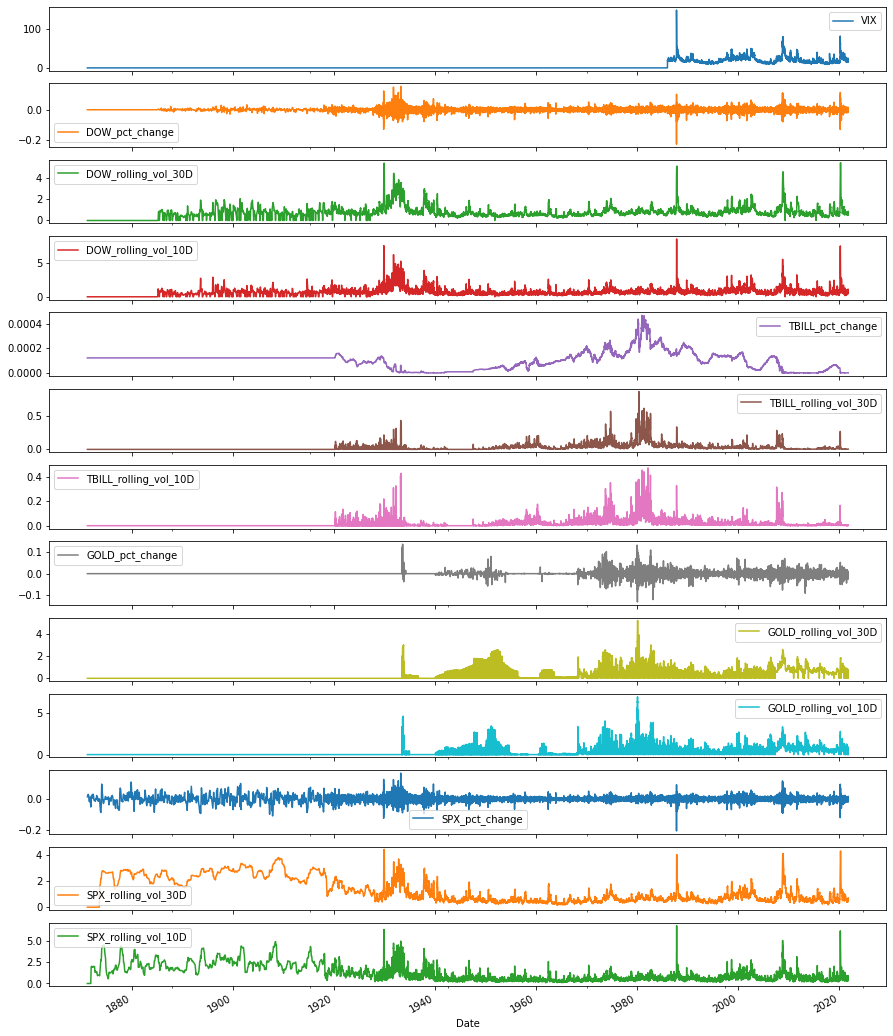

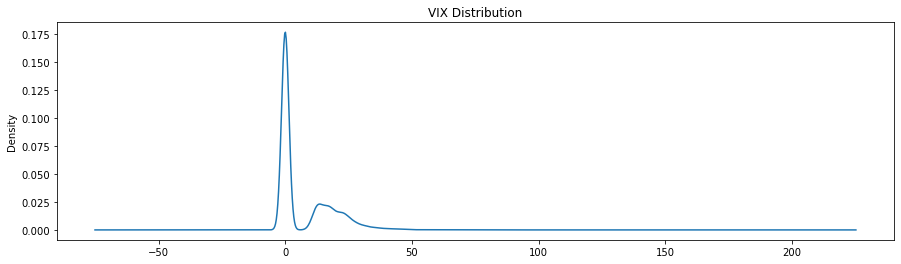

In [4]:
data.plot('Date', subplots=True, figsize = (15,20))
plt.show()

data['VIX'].plot(kind = 'kde', figsize = (15,4), title = 'VIX Distribution')
plt.show()

# Data Processing

In [5]:
def lstm_data_processing(data, start_date, end_date, n_time_steps = 90, include_vix = True):

    # Get the indices of the start date and the end date
    try:
        start_index = int(np.where(data[:,0] == pd.to_datetime(start_date))[0])
        end_index = int(np.where(data[:,0] == pd.to_datetime(end_date))[0])
    except:
        print("Make sure start_date and end_date actually exist in our dataframe")
    
    # get a list of the dates
    dates = data[start_index:end_index+1,0]
    
    # Flag to set if VIX data is included in the training set
    if include_vix:
        # Get all of the input data (X)
        X_data = data[:,1:].astype('float32')
    else:
        # Get all of the input data (X)
        X_data = data[:,2:].astype('float32')   
    
    # Create an empty array to store the restructured input data
    X_data_extended = np.zeros((X_data.shape[0], n_time_steps, X_data.shape[-1]))

    # Loop through all samples 
    for i in range(start_index, end_index+1):
        X_data_extended[i] = X_data[i-n_time_steps:i,:]
    
    # Get all of the input data (X) for the desired date range
    X_data = X_data_extended[start_index:end_index+1]

    # Get all of the output data (Y) for the desired date range
    y_data = data[start_index:end_index+1,1].astype('float32')
    
    return X_data, y_data, dates

# Define a function to process the data for Bidirectional LSTM
def bidirectional_data_processing(data, start_date, end_date, n_time_steps = 30):

    # Get the indices of the start date and the end date
    try:
        start_index = int(np.where(data[:,0] == pd.to_datetime(start_date))[0])
        end_index = int(np.where(data[:,0] == pd.to_datetime(end_date))[0])
    except:
        print("Make sure start_date and end_date actually exist in our dataframe")
    
    # get a list of the dates
    dates = data[start_index:end_index+1,0]
    
    # Get all of the input data (X)
    X_data = data[:,2:].astype('float32')
    
    # Create an empty array to store the restructured input data
    X_data_extended = np.zeros((X_data.shape[0], 2*n_time_steps+1, X_data.shape[-1]))

    # Loop through all samples 
    for i in range(start_index, end_index+1):
        X_data_extended[i] = X_data[i-n_time_steps:i+n_time_steps+1,:]
    
    # Get all of the input data (X) for the desired date range
    X_data = X_data_extended[start_index:end_index+1]

    # Get all of the output data (Y) for the desired date range
    y_data = data[start_index:end_index+1,1].astype('float32')
    
    return X_data, y_data, dates

# Convert the data from a pandas dataframe to a numpy array
np_data = data.to_numpy()

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = np_data.copy()
scaled_data[:,1:] = scaler.fit_transform(scaled_data[:,1:])

# Define the number of timesteps to look forward and backward (total number of timesteps is 2*n_timesteps+1)
n_time_steps = 30

# Split data into train, dev, and test sets
X_train, y_train, train_dates = lstm_data_processing(scaled_data, start_date = '12/31/2020', end_date = '01/02/1991', n_time_steps = n_time_steps, include_vix = False)
X_dev, y_dev, dev_dates = lstm_data_processing(scaled_data, start_date = '12/31/1990', end_date = '07/01/1988', n_time_steps = n_time_steps, include_vix = False)
X_test, y_test, test_dates = lstm_data_processing(scaled_data, start_date = '06/30/1988', end_date = '01/02/1986', n_time_steps = n_time_steps, include_vix = False)

# Verify the shapes of the input and output data
print(X_train.shape)
print(y_train.shape)
print(X_dev.shape)
print(y_dev.shape)
print(X_test.shape)
print(y_test.shape)

(7553, 30, 12)
(7553,)
(631, 30, 12)
(631,)
(630, 30, 12)
(630,)


# Basic LSTM Model

In [6]:
# Building the model
lstm_model = Sequential()

# Adding a LSTM layer
lstm_model.add(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, input_shape=(X_train.shape[1], X_train.shape[-1])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mse', optimizer='adam')

In [7]:
# Training the model
lstm = lstm_model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_dev, y_dev))

# Save the model
lstm_model.save('Models/Basic_LSTM')

Epoch 1/10
60/60 [==============================] - 3s 32ms/step - loss: 0.0106 - val_loss: 3.7810e-04
Epoch 2/10
60/60 [==============================] - 2s 30ms/step - loss: 0.0012 - val_loss: 3.2523e-04
Epoch 3/10
60/60 [==============================] - 2s 27ms/step - loss: 9.7465e-04 - val_loss: 3.5928e-04
Epoch 4/10
60/60 [==============================] - 2s 27ms/step - loss: 8.3453e-04 - val_loss: 3.2191e-04
Epoch 5/10
60/60 [==============================] - 2s 27ms/step - loss: 7.7515e-04 - val_loss: 3.1574e-04
Epoch 6/10
60/60 [==============================] - 2s 27ms/step - loss: 7.2888e-04 - val_loss: 3.1957e-04
Epoch 7/10
60/60 [==============================] - 2s 27ms/step - loss: 6.7491e-04 - val_loss: 3.0961e-04
Epoch 8/10
60/60 [==============================] - 2s 27ms/step - loss: 6.5054e-04 - val_loss: 3.6487e-04
Epoch 9/10
60/60 [==============================] - 2s 25ms/step - loss: 6.1837e-04 - val_loss: 5.8533e-04oss: 
Epoch 10/10
60/60 [=====================

In [8]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                19712     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 19,777
Trainable params: 19,777
Non-trainable params: 0
_________________________________________________________________


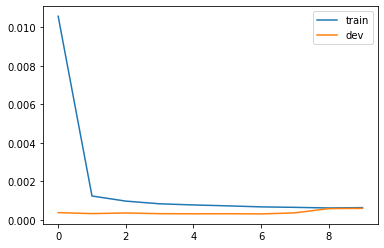

In [9]:
# plot training and dev losses over epoch
plt.plot(lstm.history['loss'], label='train')
plt.plot(lstm.history['val_loss'], label='dev')
plt.legend()
plt.show()

### Basic LSTM Model Prediction and Visualization

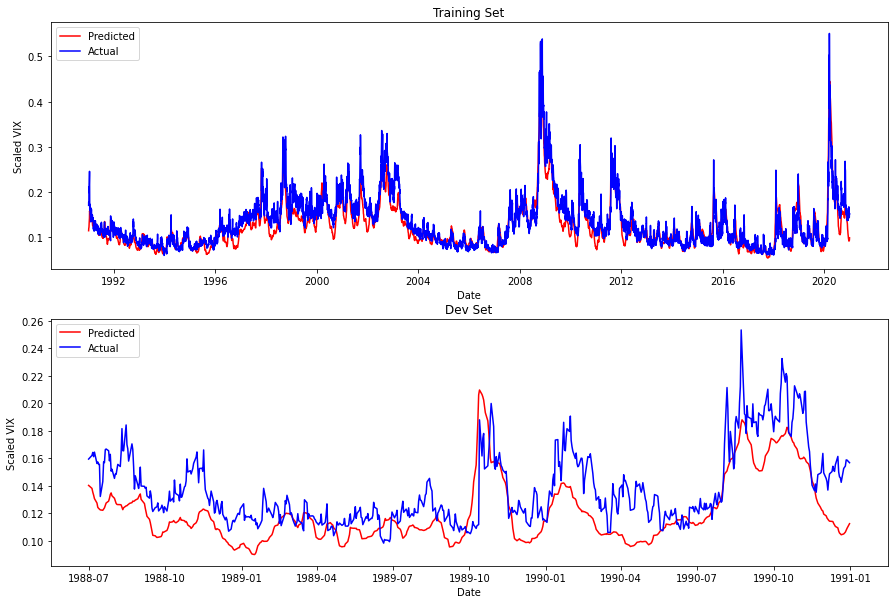

In [10]:
# make predictions for the training and dev sets
y_train_hat = lstm_model.predict(X_train)
y_dev_hat = lstm_model.predict(X_dev)

# Showing the predicted vs. actual values
fig, axs = plt.subplots(2,1)
fig.set_figheight(10)
fig.set_figwidth(15)

# Plot for the training set
axs[0].plot(train_dates, y_train_hat, color='red', label='Predicted')
axs[0].plot(train_dates, y_train, color='blue', label='Actual')
axs[0].set_title('Training Set')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Scaled VIX')
axs[0].legend(loc='upper left')

# Plot for the dev set
axs[1].plot(dev_dates, y_dev_hat, color='red', label='Predicted')
axs[1].plot(dev_dates, y_dev, color='blue', label='Actual')
axs[1].set_title('Dev Set')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Scaled VIX')
axs[1].legend(loc='upper left')

plt.savefig('Figures/Basic_LSTM_Predictions.png')
plt.show()

# Bi-LSTM

### Without hyperparameter tuning:

In [11]:
bi_lstm_model = Sequential()
bi_lstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[-1])))
bi_lstm_model.add(Bidirectional(LSTM(64)))
bi_lstm_model.add(Dense(1))
bi_lstm_model.compile(loss='mse', optimizer='adam')

In [12]:
# Training the model
bi_lstm = bi_lstm_model.fit(X_train, y_train, batch_size=128, epochs=25, validation_data=(X_dev, y_dev))

# Save the model
bi_lstm_model.save('Models/Bi_LSTM_Untuned')

Epoch 1/25
60/60 [==============================] - 9s 71ms/step - loss: 0.0020 - val_loss: 2.9832e-04
Epoch 2/25
60/60 [==============================] - 4s 59ms/step - loss: 5.2257e-04 - val_loss: 4.9027e-04
Epoch 3/25
60/60 [==============================] - 4s 59ms/step - loss: 5.1352e-04 - val_loss: 3.0749e-04
Epoch 4/25
60/60 [==============================] - 4s 59ms/step - loss: 4.8026e-04 - val_loss: 4.7121e-04
Epoch 5/25
60/60 [==============================] - 4s 62ms/step - loss: 5.5713e-04 - val_loss: 3.6790e-04
Epoch 6/25
60/60 [==============================] - 4s 64ms/step - loss: 4.7105e-04 - val_loss: 8.0440e-04
Epoch 7/25
60/60 [==============================] - 4s 67ms/step - loss: 4.9103e-04 - val_loss: 4.1398e-04
Epoch 8/25
60/60 [==============================] - 4s 65ms/step - loss: 4.6159e-04 - val_loss: 7.0593e-04
Epoch 9/25
60/60 [==============================] - 4s 64ms/step - loss: 5.4254e-04 - val_loss: 6.2331e-04
Epoch 10/25
60/60 [======================

INFO:tensorflow:Assets written to: Models/Bi_LSTM_Untuned\assets


INFO:tensorflow:Assets written to: Models/Bi_LSTM_Untuned\assets


In [13]:
bi_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 30, 128)           39424     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
_________________________________________________________________


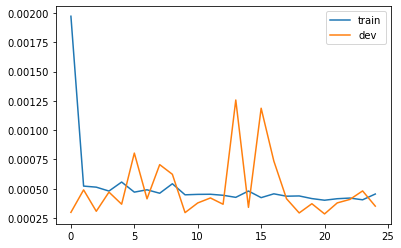

In [14]:
# plot training and dev losses over epoch
plt.plot(bi_lstm.history['loss'], label='train')
plt.plot(bi_lstm.history['val_loss'], label='dev')
plt.legend()
plt.show()

### With hyperparameter tuning:

In [15]:
import keras_tuner as kt

In [16]:
# Keras-Tuner helper method, used for tuning
def build_bi_lstm_model(hp):
    bi_lstm_model = Sequential()
    
    # initialize i in case the number of layers is only 1:
    i = 0
    
    # Tune the number of layers
    for i in range(1, hp.Int("num_layers", 1, 3)):
        # Bidirectional LSTM layer i
        bi_lstm_model.add(Bidirectional(LSTM(
            units=hp.Choice(f'units_{i}', [16,32,64,128]),
            return_sequences=True, 
            dropout=hp.Float(f"dropout_{i}", min_value=0.0, max_value=0.5, step = 0.05),
            recurrent_dropout=hp.Float(f"recurrent_dropout_{i}", min_value=0.0, max_value=0.5, step = 0.1))))
    
    # Last Bidirectional LSTM layer
    bi_lstm_model.add(Bidirectional(LSTM(
        units=hp.Choice(f'units_{i+1}', [16,32,64,128]),
        return_sequences=False, 
        dropout=hp.Float(f"dropout_{i+1}", min_value=0.0, max_value=0.5, step = 0.05),
        recurrent_dropout=hp.Float(f"recurrent_dropout_{i+1}", min_value=0.0, max_value=0.5, step = 0.1))))
    
    # Fully-connected layer with output 1
    bi_lstm_model.add(Dense(1))
    
    # Tune the learning rate
    opt = Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log"))
    
    bi_lstm_model.compile(loss='mse', optimizer=opt)
    return bi_lstm_model

In [17]:
# This will read in hyperparameters from the last time that the RandomSearch was performed, 
# if the untitlied_project folder is in the current directory
tuner = kt.RandomSearch(
    build_bi_lstm_model,
    objective='val_loss',
    max_trials= 150,
    directory = 'Hyperparameter_Tuning')

INFO:tensorflow:Reloading Oracle from existing project Hyperparameter_Tuning\untitled_project\oracle.json


INFO:tensorflow:Reloading Oracle from existing project Hyperparameter_Tuning\untitled_project\oracle.json


INFO:tensorflow:Reloading Tuner from Hyperparameter_Tuning\untitled_project\tuner0.json


INFO:tensorflow:Reloading Tuner from Hyperparameter_Tuning\untitled_project\tuner0.json


In [18]:
# Search for best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_data=(X_dev, y_dev),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [19]:
tuner.results_summary()

Results summary
Results in Hyperparameter_Tuning\untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
num_layers: 2
units_1: 32
dropout_1: 0.0
recurrent_dropout_1: 0.2
lr: 0.002175223112173724
units_2: 16
dropout_2: 0.15000000000000002
recurrent_dropout_2: 0.2
units_3: 64
dropout_3: 0.45
recurrent_dropout_3: 0.30000000000000004
Score: 0.00027071466320194304
Trial summary
Hyperparameters:
num_layers: 3
units_1: 32
dropout_1: 0.05
recurrent_dropout_1: 0.4
lr: 0.0004179831907993772
units_2: 32
dropout_2: 0.2
recurrent_dropout_2: 0.2
units_3: 16
dropout_3: 0.35000000000000003
recurrent_dropout_3: 0.4
Score: 0.0002714307338465005
Trial summary
Hyperparameters:
num_layers: 3
units_1: 32
dropout_1: 0.15000000000000002
recurrent_dropout_1: 0.2
lr: 0.007340641230095153
units_2: 16
dropout_2: 0.0
recurrent_dropout_2: 0.4
units_3: 64
dropout_3: 0.2
recurrent_dropout_3: 0.30000000000000004
Score: 0.0002721464552450925
Trial summary
Hype

In [20]:
# Retrieve best model (model with the best hyperparameters)
best_model = tuner.get_best_models()[0]

# Fit this model to the training data
best_bi_lstm = best_model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_dev, y_dev),
                             callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Save the model
best_model.save('Models/Bi_LSTM_Tuned')

Epoch 1/50
60/60 [==============================] - 9s 59ms/step - loss: 5.0851e-04 - val_loss: 4.3976e-04
Epoch 2/50
60/60 [==============================] - 3s 44ms/step - loss: 4.7620e-04 - val_loss: 2.7762e-04
Epoch 3/50
60/60 [==============================] - 3s 49ms/step - loss: 4.7705e-04 - val_loss: 5.8837e-04
Epoch 4/50
60/60 [==============================] - 3s 56ms/step - loss: 4.6551e-04 - val_loss: 3.3032e-04
Epoch 5/50
60/60 [==============================] - 3s 56ms/step - loss: 4.8692e-04 - val_loss: 4.0514e-04
Epoch 6/50
60/60 [==============================] - 3s 52ms/step - loss: 5.4590e-04 - val_loss: 5.0638e-04
Epoch 7/50
60/60 [==============================] - 3s 52ms/step - loss: 4.5463e-04 - val_loss: 3.4885e-04
INFO:tensorflow:Assets written to: Models/Bi_LSTM_Tuned\assets


INFO:tensorflow:Assets written to: Models/Bi_LSTM_Tuned\assets


In [21]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 30, 64)            11520     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 21,921
Trainable params: 21,921
Non-trainable params: 0
_________________________________________________________________


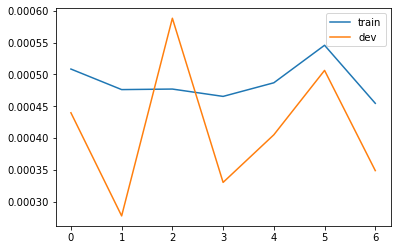

In [22]:
# plot training and dev losses over epoch
plt.plot(best_bi_lstm.history['loss'], label='train')
plt.plot(best_bi_lstm.history['val_loss'], label='dev')
plt.legend()
plt.show()

### Bi-LSTM Model Prediction and Visualization

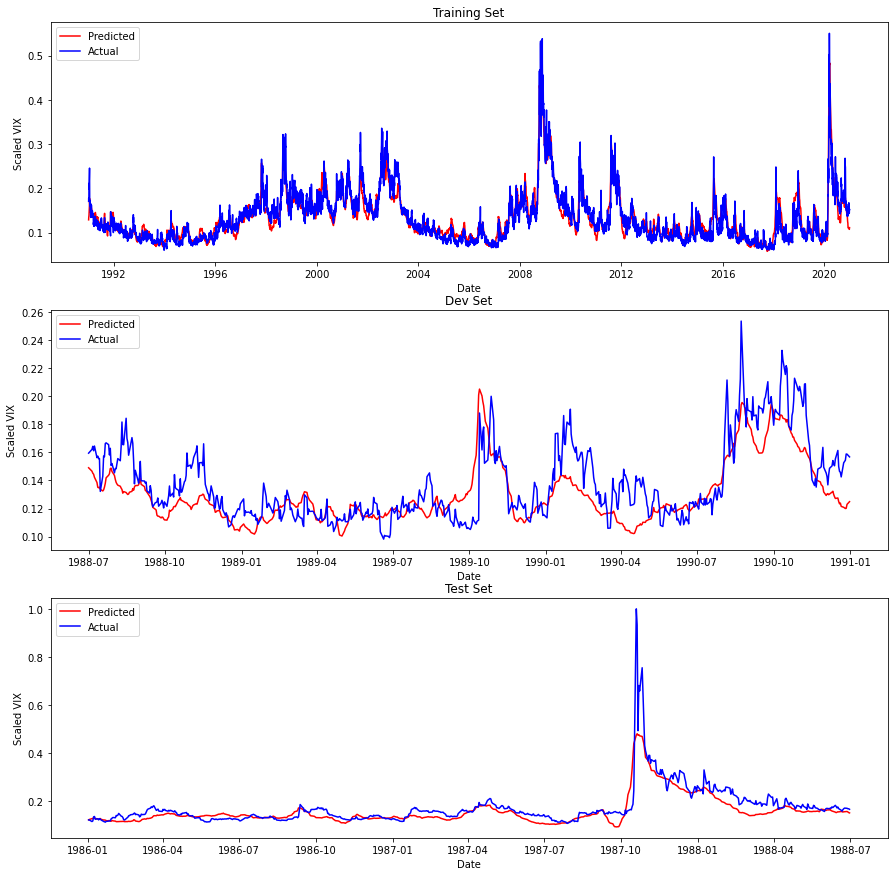

In [23]:
# make predictions for the training and dev sets
y_train_hat = best_model.predict(X_train)
y_dev_hat = best_model.predict(X_dev)
y_test_hat = best_model.predict(X_test)

# Showing the predicted vs. actual values
fig, axs = plt.subplots(3,1)
fig.set_figheight(15)
fig.set_figwidth(15)

# Plot for the training set
axs[0].plot(train_dates, y_train_hat, color='red', label='Predicted')
axs[0].plot(train_dates, y_train, color='blue', label='Actual')
axs[0].set_title('Training Set')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Scaled VIX')
axs[0].legend(loc='upper left')

# Plot for the dev set
axs[1].plot(dev_dates, y_dev_hat, color='red', label='Predicted')
axs[1].plot(dev_dates, y_dev, color='blue', label='Actual')
axs[1].set_title('Dev Set')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Scaled VIX')
axs[1].legend(loc='upper left')

# Plot for the test set
axs[2].plot(test_dates, y_test_hat, color='red', label='Predicted')
axs[2].plot(test_dates, y_test, color='blue', label='Actual')
axs[2].set_title('Test Set')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Scaled VIX')
axs[2].legend(loc='upper left')

plt.savefig('Figures/BiLSTM_Predictions.png')
plt.show()

## Experimenting with Loss Functions

In [24]:
# import the functions needed for the custom loss function
from tensorflow.math import reduce_mean, pow

# Define the custom loss function
def m4e(y_true, y_pred):
    return reduce_mean(pow(y_true - y_pred, 4), axis=-1)

In [25]:
# Helper function to build the bidirectional LSTM model with a specified loss function
def build_bi_lstm_model_loss(loss='mse'):
    bi_lstm_model = Sequential()
    
    # Bidirectional LSTM layer 1
    bi_lstm_model.add(Bidirectional(LSTM(
        units=32,
        return_sequences=True, 
        dropout=0.0,
        recurrent_dropout=0.2,
        input_shape=(X_train.shape[1], X_train.shape[-1]))))
    
    # Bidirectional LSTM layer 2
    bi_lstm_model.add(Bidirectional(LSTM(
        units=32,
        return_sequences=True, 
        dropout=0.2,
        recurrent_dropout=0.2)))
    
    # Bidirectional LSTM layer 3
    bi_lstm_model.add(Bidirectional(LSTM(
        units=16,
        return_sequences=False, 
        dropout=0.35,
        recurrent_dropout=0.35)))
    
    # Fully-connected layer with output 1
    bi_lstm_model.add(Dense(1))
    
    # Optimizer
    opt = Adam(learning_rate=0.005)
    
    # Define the loss function based on the passed argument
    if loss == 'm4e':
        bi_lstm_model.compile(loss=m4e, optimizer=opt)
    elif loss == 'm8e':
        bi_lstm_model.compile(loss=m8e, optimizer=opt)
    else:
        bi_lstm_model.compile(loss=loss, optimizer=opt)
        
    return bi_lstm_model

# Construct the Bidirectional LSTM models with the different loss functions
bi_lstm_mae_model = build_bi_lstm_model_loss(loss='mae')
bi_lstm_mse_model = build_bi_lstm_model_loss(loss='mse')
bi_lstm_m4e_model = build_bi_lstm_model_loss(loss='m4e')

# Put all of the models in a list to loop through
loss_models = [[bi_lstm_mae_model, 'MAE'],
               [bi_lstm_mse_model, 'MSE'], 
               [bi_lstm_m4e_model, 'M4E']]

In [26]:
# Fit the models to the training data
for model in loss_models:
    print(model[1] + ":")
    model[0].fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_dev, y_dev),
                callbacks=[EarlyStopping(monitor='val_loss', patience=5)])
    
    # Save the model
    model[0].save('Models/Bi_LSTM_' + model[1])

MAE:
Epoch 1/50
60/60 [==============================] - 15s 107ms/step - loss: 0.0463 - val_loss: 0.0259
Epoch 2/50
60/60 [==============================] - 6s 102ms/step - loss: 0.0209 - val_loss: 0.0180
Epoch 3/50
60/60 [==============================] - 7s 109ms/step - loss: 0.0193 - val_loss: 0.0246
Epoch 4/50
60/60 [==============================] - 7s 111ms/step - loss: 0.0202 - val_loss: 0.0127
Epoch 5/50
60/60 [==============================] - 7s 116ms/step - loss: 0.0169 - val_loss: 0.0307
Epoch 6/50
60/60 [==============================] - 7s 113ms/step - loss: 0.0175 - val_loss: 0.0248
Epoch 7/50
60/60 [==============================] - 6s 101ms/step - loss: 0.0173 - val_loss: 0.0322
Epoch 8/50
60/60 [==============================] - 6s 101ms/step - loss: 0.0176 - val_loss: 0.0131
Epoch 9/50
60/60 [==============================] - 6s 100ms/step - loss: 0.0166 - val_loss: 0.0277
INFO:tensorflow:Assets written to: Models/Bi_LSTM_MAE\assets


INFO:tensorflow:Assets written to: Models/Bi_LSTM_MAE\assets


MSE:
Epoch 1/50
60/60 [==============================] - 17s 146ms/step - loss: 0.0116 - val_loss: 3.4779e-04
Epoch 2/50
60/60 [==============================] - 8s 141ms/step - loss: 7.2492e-04 - val_loss: 2.8394e-04
Epoch 3/50
60/60 [==============================] - 9s 149ms/step - loss: 6.4930e-04 - val_loss: 3.4944e-04
Epoch 4/50
60/60 [==============================] - 8s 138ms/step - loss: 6.6749e-04 - val_loss: 3.5641e-04
Epoch 5/50
60/60 [==============================] - 8s 140ms/step - loss: 6.5251e-04 - val_loss: 3.4447e-04
Epoch 6/50
60/60 [==============================] - 8s 137ms/step - loss: 5.7625e-04 - val_loss: 2.7962e-04
Epoch 7/50
60/60 [==============================] - 8s 137ms/step - loss: 5.7082e-04 - val_loss: 2.8792e-04
Epoch 8/50
60/60 [==============================] - 8s 141ms/step - loss: 5.2402e-04 - val_loss: 6.4200e-04
Epoch 9/50
60/60 [==============================] - 9s 153ms/step - loss: 5.4612e-04 - val_loss: 3.2933e-04
Epoch 10/50
60/60 [=======

INFO:tensorflow:Assets written to: Models/Bi_LSTM_MSE\assets


M4E:
Epoch 1/50
60/60 [==============================] - 18s 150ms/step - loss: 8.3317e-04 - val_loss: 1.7530e-06
Epoch 2/50
60/60 [==============================] - 9s 145ms/step - loss: 7.5775e-06 - val_loss: 9.2735e-07
Epoch 3/50
60/60 [==============================] - 9s 153ms/step - loss: 5.4356e-06 - val_loss: 6.7523e-07
Epoch 4/50
60/60 [==============================] - 9s 148ms/step - loss: 4.6044e-06 - val_loss: 4.9473e-07
Epoch 5/50
60/60 [==============================] - 9s 147ms/step - loss: 3.9210e-06 - val_loss: 4.5837e-07
Epoch 6/50
60/60 [==============================] - 9s 149ms/step - loss: 3.9352e-06 - val_loss: 4.3253e-07
Epoch 7/50
60/60 [==============================] - 9s 150ms/step - loss: 3.2421e-06 - val_loss: 4.3752e-07
Epoch 8/50
60/60 [==============================] - 9s 145ms/step - loss: 3.2050e-06 - val_loss: 4.4397e-07
Epoch 9/50
60/60 [==============================] - 9s 146ms/step - loss: 3.2042e-06 - val_loss: 4.7103e-07
Epoch 10/50
60/60 [===

INFO:tensorflow:Assets written to: Models/Bi_LSTM_M4E\assets


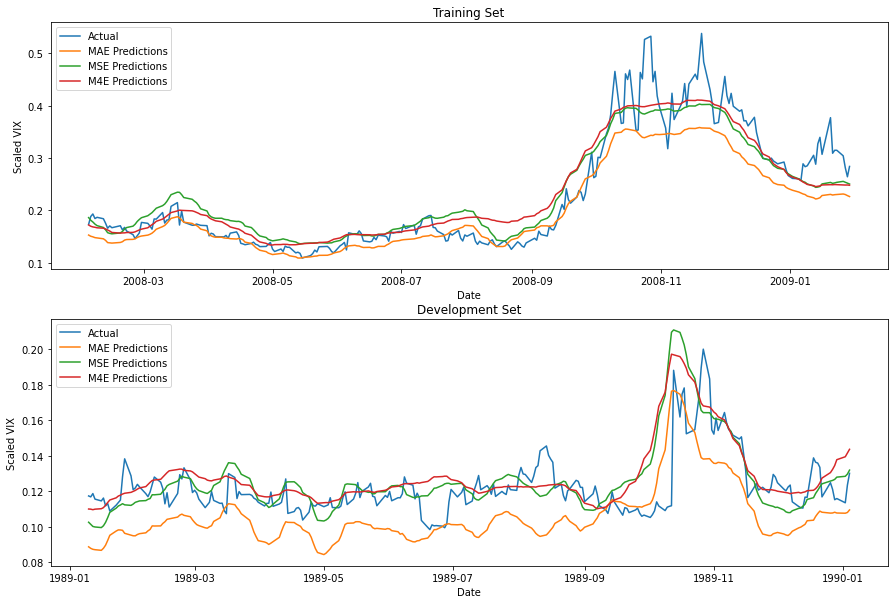

In [27]:
# Plot the predictions of the loss functions

# Create a plot for the training and dev data
fig, axs = plt.subplots(2,1)
fig.set_figheight(10)
fig.set_figwidth(15)

# Set the titles and axis labels for both subplots
axs[0].set_title('Training Set')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Scaled VIX')

axs[1].set_title('Development Set')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Scaled VIX')

# Plot only an interesting subset of the target output of the training and dev data
axs[0].plot(train_dates[3000:3250], y_train[3000:3250], label= 'Actual')
axs[1].plot(dev_dates[250:500], y_dev[250:500], label= 'Actual')

# Loop through the models with different loss functions
for model in loss_models:
    # make predictions for the training and dev sets
    y_train_hat = model[0].predict(X_train)
    y_dev_hat = model[0].predict(X_dev)
    
    # plot the predictions for the training set
    axs[0].plot(train_dates[3000:3250], y_train_hat[3000:3250], label=model[1] + ' Predictions')
    axs[1].plot(dev_dates[250:500], y_dev_hat[250:500], label=model[1] + ' Predictions')

# Add a legend and show the plots
axs[0].legend(loc='upper left')
axs[1].legend(loc='upper left')

plt.savefig('Figures/Loss_Function_Predictions.png')
plt.show()

# Training Best Bi-LSTM Model on Full Dataset

In [28]:
# Get the training set for all dates where VIX data is available
X_full_train, y_full_train, full_train_dates = lstm_data_processing(scaled_data, start_date = '12/31/2020', end_date = '01/02/1986', n_time_steps = n_time_steps, include_vix = False)
X_backfill, y_backfill, backfill_dates = lstm_data_processing(scaled_data, start_date = '12/31/1985', end_date = '01/02/1969', n_time_steps = n_time_steps, include_vix = False)

# Load the tuned Bi-LSTM model
bi_lstm_tuned_full_model = load_model('Models/Bi_LSTM_Tuned')

# Fit the tuned model to the full training set
bi_lstm_tuned_full_model.fit(X_full_train, y_full_train, batch_size=128, epochs=10)

# Save the model
bi_lstm_tuned_full_model.save('Models/Bi_LSTM_Tuned_Full_Dataset')

Epoch 1/10
69/69 [==============================] - 12s 80ms/step - loss: 6.2862e-04
Epoch 2/10
69/69 [==============================] - 6s 85ms/step - loss: 5.4209e-04
Epoch 3/10
69/69 [==============================] - 6s 83ms/step - loss: 5.4277e-04
Epoch 4/10
69/69 [==============================] - 6s 83ms/step - loss: 5.1288e-04
Epoch 5/10
69/69 [==============================] - 6s 86ms/step - loss: 5.2149e-04
Epoch 6/10
69/69 [==============================] - 6s 83ms/step - loss: 5.0173e-04
Epoch 7/10
69/69 [==============================] - 6s 83ms/step - loss: 5.0987e-04
Epoch 8/10
69/69 [==============================] - 6s 84ms/step - loss: 5.1625e-04
Epoch 9/10
69/69 [==============================] - 6s 83ms/step - loss: 5.0390e-04
Epoch 10/10
69/69 [==============================] - 6s 82ms/step - loss: 4.8285e-04
INFO:tensorflow:Assets written to: Models/Bi_LSTM_Tuned_Full_Dataset\assets


INFO:tensorflow:Assets written to: Models/Bi_LSTM_Tuned_Full_Dataset\assets


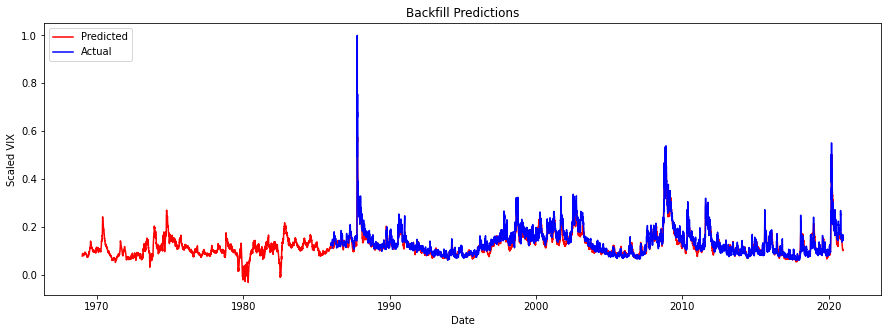

In [29]:
# Use the model to backfill VIX
y_full_train_hat = bi_lstm_tuned_full_model.predict(X_full_train)
y_backfill_hat = bi_lstm_tuned_full_model.predict(X_backfill)

# Save the backfill dates and predictions
np.savez('Backfill/backfill_data', backfill_dates = backfill_dates, y_backfill_hat = y_backfill_hat)

# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)

axs.plot(full_train_dates, y_full_train_hat, color='red', label='Predicted')
axs.plot(full_train_dates, y_full_train, color='blue', label='Actual')
axs.plot(backfill_dates, y_backfill_hat, color='red')
plt.title('Backfill Predictions')
plt.xlabel('Date')
plt.ylabel('Scaled VIX')
plt.legend(loc='upper left')
plt.show()